In [1]:
import os
from pipeline_functionality import preprocess_data
from pipeline_functionality import preprocess_training_validation
from pipeline_functionality import feature_engineering
from pipeline_functionality import NeuralNetwork
from pipeline_functionality import TrainingValidatingNetwork
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy.stats import f_oneway
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
preprocess = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df = preprocess.read_df()

Checking for missing values

In [3]:
df.isna().sum()

Feature 0     1
Feature 1     1
Feature 2     0
Feature 3     0
Feature 4     0
Feature 5     0
Feature 6     0
Feature 7     0
Age           0
Sex           0
Feature 10    1
label         0
dtype: int64

In [4]:
df[(df["Feature 0"].isna()) & (df["Feature 1"].isna()) & (df["Feature 10"].isna())]

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
39,NaN,NaN,1336.54,739.71,550.3,68.46,192.07,1615.68,21,0,NaN,0


There is only one instance of missing values, hence we shall drop that off

In [5]:
df = df.dropna(subset=["Feature 0","Feature 1","Feature 10"])
df

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,626.0,68.0,1771.57,666.99,1117.48,360.21,118.84,2306.82,42,1,1521.0,0
83,1237.0,71.0,1348.53,428.09,924.69,120.02,48.67,1524.78,56,0,1345.0,0
84,634.0,1002.0,1300.00,558.00,724.00,67.00,105.00,1484.26,34,0,2926.0,1
85,112.0,884.0,942.83,378.49,567.06,116.77,31.81,1104.59,33,1,2352.0,1


In [6]:
df = df.reset_index(drop=True)

Number of 0:  57
Number of 1:  29


c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


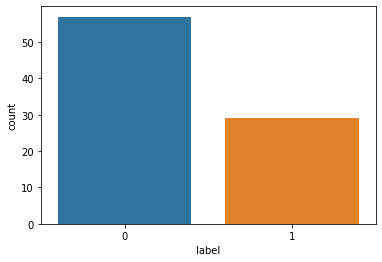

In [7]:
# count = Counter(df_label)

# fig,ax_hist = plt.subplots(1,1,figsize = (8,8))
# ax_hist.bar(x = list(count.keys()),height=[count[k] for k in count.keys()])
sns.countplot(df["label"],label = "Count")
B, M = df["label"].value_counts()
print('Number of 0: ',B)
print('Number of 1: ',M)

Data is imbalanced, hence the minority class needs to be oversampled

In [8]:
oversample = SMOTE()
df_train,df_label = oversample.fit_resample(df[[i for i in df.columns.tolist() if i!="label"]],df[[i for i in df.columns.tolist() if i=="label"]])
# df_train,df_label = df[[i for i in df.columns.tolist() if i!="label"]],df[[i for i in df.columns.tolist() if i=="label"]]

Number of 0:  57
Number of 1:  57


c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


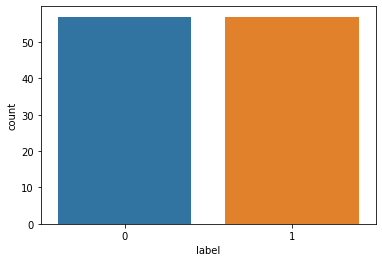

In [9]:
sns.countplot(df_label["label"],label = "Count")
B, M = df_label["label"].value_counts()
print('Number of 0: ',B)
print('Number of 1: ',M)

In [10]:
df.isna().sum()

Feature 0     0
Feature 1     0
Feature 2     0
Feature 3     0
Feature 4     0
Feature 5     0
Feature 6     0
Feature 7     0
Age           0
Sex           0
Feature 10    0
label         0
dtype: int64

EDA will be done on a smaller subset of the dataset, while cross validation will be done using K Fold Cross Validation. 
From the results of EDA, the pipeline will be made to process the entire dataset as per the findings of EDA

In [11]:
# df_eda,df_validation,y_eda,y_validation = train_test_split(df_train,df_label,test_size = 0.2, random_state=42,stratify=df_label)
df_eda,df_validation,y_eda,y_validation = train_test_split(df_train,df_label,test_size = 0.2, random_state=42,stratify=df_label)

In [12]:
# preprocess_eda = preprocess_training_validation()
# df_eda_normalized = preprocess_eda.normalize(df_eda)

In [13]:
# df_validation_normalized = preprocess_eda.normalize(df_validation)

In [14]:
df_eda["label"] = y_eda
# df_eda["labels"] = y_eda

In [15]:
df_eda

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Sex,Feature 10,label
86,122.092373,802.409850,916.221397,376.728091,542.004163,104.760076,46.789271,1079.348123,31,1,2363.308322,1
89,441.442294,359.188791,476.716189,239.674575,237.048133,96.394635,200.920150,774.061540,30,0,574.129424,1
19,403.000000,555.000000,313.480000,131.530000,182.690000,46.680000,7.900000,370.300000,40,0,2209.000000,1
53,1558.000000,611.000000,359.150000,148.650000,191.800000,20.620000,81.520000,467.040000,49,1,2189.000000,1
26,2088.000000,98.000000,962.300000,533.030000,459.720000,370.880000,142.890000,1477.310000,51,1,1599.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
38,1010.000000,1384.000000,570.130000,312.900000,233.840000,80.170000,31.180000,702.080000,56,1,5501.000000,1
56,365.000000,248.000000,300.750000,195.070000,106.580000,13.420000,52.910000,371.300000,41,1,866.000000,1
58,631.000000,182.000000,675.100000,280.090000,386.570000,136.000000,56.230000,875.410000,29,1,3990.000000,0
42,1679.000000,79.000000,483.210000,162.000000,309.000000,227.050000,101.090000,817.240000,39,0,4480.000000,0


In [16]:
# df_eda_normalized_melt = pd.melt(df_eda_normalized,id_vars='labels',var_name='features',value_name='values')
df_eda_melt = pd.melt(df_eda,id_vars='label',var_name='features',value_name='values')
df_eda_melt

,label,features,values
0,1,Feature 0,122.092373
1,1,Feature 0,441.442294
2,1,Feature 0,403.000000
3,1,Feature 0,1558.000000
4,1,Feature 0,2088.000000
...,...,...,...
996,1,Feature 10,5501.000000
997,1,Feature 10,866.000000
998,0,Feature 10,3990.000000
999,0,Feature 10,4480.000000


In [17]:
#One way ANOVA test
def oneway_anova(class1,class2):
    stat,pval = f_oneway(class1,class2)
    if pval < 0.05:
        print(f"Mean difference is statistically significant with pvalue of {pval}")
    else:
        print(f"Mean difference is statistically not significant with pvalue of {pval}")

<h3>Feature Engineering</h3>

- Violin plots on each feature to identify the features that cause the best class separation
- Use Swarm plots too
- Use PCA to check if there is a better visualization of data that can be shown
- One way Anova tests to identify which features have statistically significant differences in feature
- Correlation between each feature to be investigated


Drawing Violin Plots for each feature at hand

<AxesSubplot:xlabel='features', ylabel='values'>

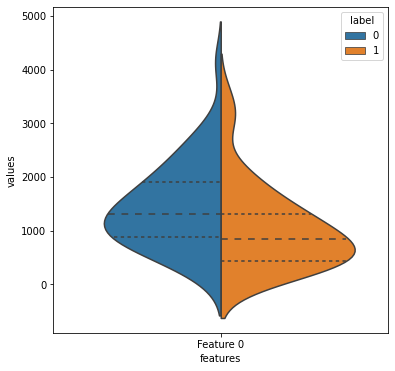

In [18]:
fig,ax_feature1 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],split = True,ax = ax_feature1,inner='quartile')

In [19]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 0"],df_eda.loc[df_eda["label"] == 1]["Feature 0"])

Mean difference is statistically significant with pvalue of 0.01915347254252515


Conclusion:

Feature 0: MO HLADR+ MFI (cells/ul)

The mean value of each class for Feature 0 is significantly different. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

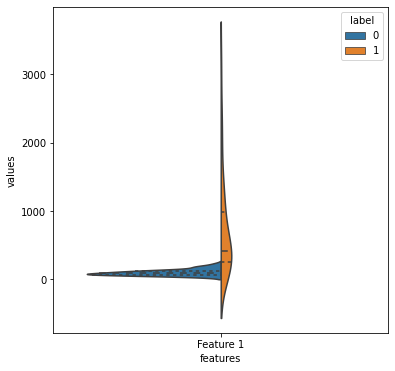

In [20]:
fig,ax_feature2 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],split = True,ax = ax_feature2,inner='quartile')

In [21]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 1"],df_eda.loc[df_eda["label"] == 1]["Feature 1"])

Mean difference is statistically significant with pvalue of 5.062496239172929e-08


Conclusion:

Feature 1: Neu CD64+MFI (cells/ul)

The mean value of each class for Feature 1 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. As seen in the violin plot, it is clear that label 0 only exists in a small range of values, while label 1 exists in a larger range. This can be used to create a categorical variable for Feature 1.

<AxesSubplot:xlabel='features', ylabel='values'>

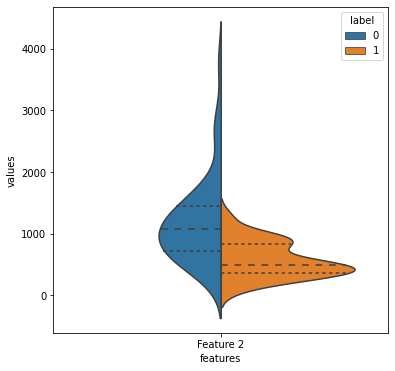

In [22]:
fig,ax_feature3 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],split = True,ax = ax_feature3,inner='quartile')

In [23]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 2"],df_eda.loc[df_eda["label"] == 1]["Feature 2"])

Mean difference is statistically significant with pvalue of 3.251566279685463e-07


Conclusion:

Feature 2: CD3+T (cells/ul)

The mean value of each class for Feature 2 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

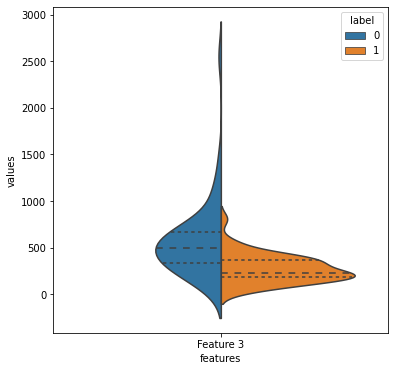

In [24]:
fig,ax_feature4 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],split = True,ax = ax_feature4,inner='quartile')

In [25]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 3"],df_eda.loc[df_eda["label"] == 1]["Feature 3"])

Mean difference is statistically significant with pvalue of 1.4595945118207698e-05


Conclusion:

Feature 3: CD8+T (cells/ul)

The mean value of each class for Feature 3 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

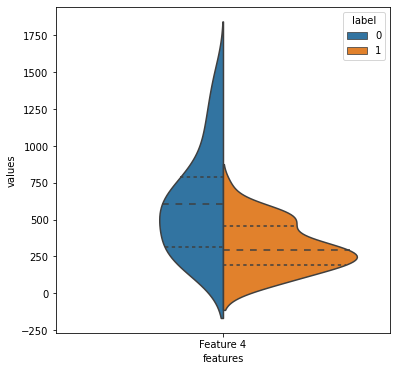

In [26]:
fig,ax_feature5 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],split = True,ax = ax_feature5,inner='quartile')

In [27]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 4"],df_eda.loc[df_eda["label"] == 1]["Feature 4"])

Mean difference is statistically significant with pvalue of 1.0902295021198465e-06


Conclusion:

Feature 4: CD4+T (cells/ul)

The mean value of each class for Feature 4 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

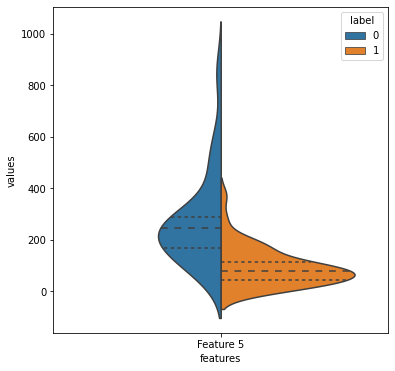

In [28]:
fig,ax_feature6 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],split = True,ax = ax_feature6,inner='quartile')

In [29]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 5"],df_eda.loc[df_eda["label"] == 1]["Feature 5"])

Mean difference is statistically significant with pvalue of 1.5175664878699954e-08


Conclusion:

Feature 5: NK (cells/ul)

The mean value of each class for Feature 5 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. We can see that 75% of all class 1 cases occur before the 25th percentile value of label 0. Hence we can create a new categorical variable on label 1 which labels training instances as high risk if NK (cells/ul) is below the 75th percentile line of Feature 5 with respect to label 1.

<AxesSubplot:xlabel='features', ylabel='values'>

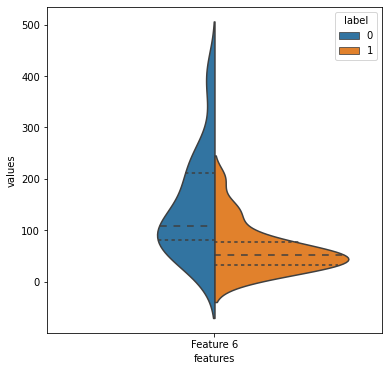

In [30]:
fig,ax_feature7 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],split = True,ax = ax_feature7,inner='quartile')

In [31]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 6"],df_eda.loc[df_eda["label"] == 1]["Feature 6"])

Mean difference is statistically significant with pvalue of 1.8035000102875376e-06


Conclusion:

Feature 6: CD19+ (cells/ul)

The mean value of each class for Feature 6 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels.

<AxesSubplot:xlabel='features', ylabel='values'>

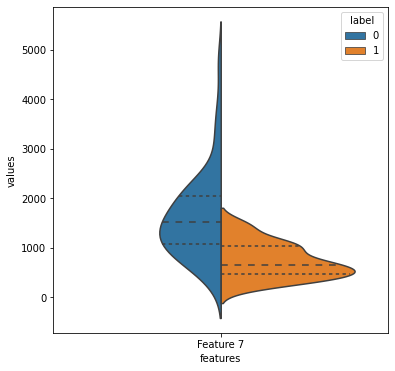

In [32]:
fig,ax_feature8 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],split = True,ax = ax_feature8,inner='quartile')

In [33]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 7"],df_eda.loc[df_eda["label"] == 1]["Feature 7"])

Mean difference is statistically significant with pvalue of 6.1986173093273715e-09


Conclusion:

Feature 7: CD45+ (cells/ul)

The mean value of each class for Feature 7 is significantly different with a very low p value. Hence it can act as a good feature to separate classification of labels. We can see that 75% of all class 1 cases occur before the 25th percentile value of label 0. Hence we can create a new categorical variable on label 1 which labels training instances as high risk if CD45+ (cells/ul) is below the 75th percentile line of Feature 7 with respect to label 1.

<AxesSubplot:xlabel='features', ylabel='values'>

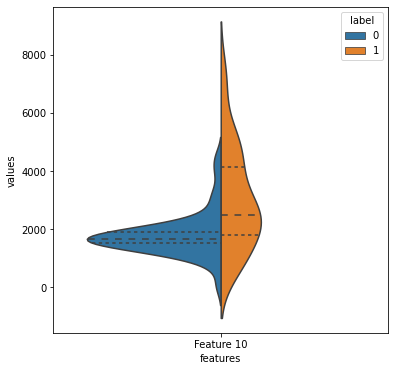

In [34]:
fig,ax_feature9 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],split = True,ax = ax_feature9,inner='quartile')

In [35]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Feature 10"],df_eda.loc[df_eda["label"] == 1]["Feature 10"])

Mean difference is statistically significant with pvalue of 4.3799182747512244e-05


Conclusion:

Feature 10: Mono CD64+MFI (cells/ul)

The mean value of each class for Feature 10 is significantly different. Hence it can act as a good feature to separate classification of labels. 

From the above analysis, the features other than Feature 0 and Feature 10, can act as very good features to do classification on. While Feature 0 and Feature 10 are satistically different in mean, their p values are not low compared to the other Features

Age

<AxesSubplot:xlabel='features', ylabel='values'>

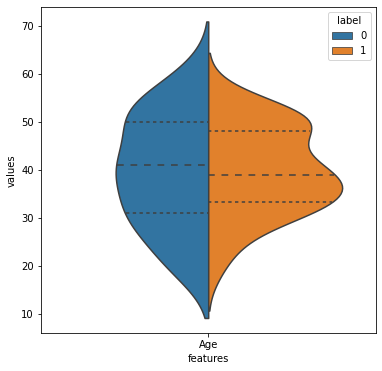

In [36]:
fig,ax_feature10 = plt.subplots(1,1,figsize = (6,6))
sns.violinplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Age"])],split = True,ax = ax_feature10,inner='quartile')

In [37]:
oneway_anova(df_eda.loc[df_eda["label"] == 0]["Age"],df_eda.loc[df_eda["label"] == 1]["Age"])

Mean difference is statistically not significant with pvalue of 0.9171005628492215


Conclusion:

Feature: Age

The mean value of each class for Age is not significantly different as seen by both the violin plot and the pvalue of the ANOVA test, which is grester than 0.05.

Sex

<AxesSubplot:xlabel='Sex', ylabel='count'>

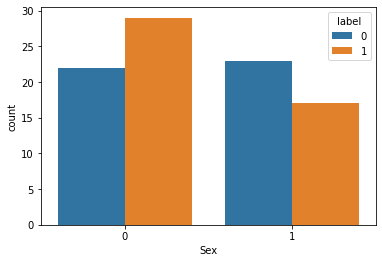

In [38]:
sns.countplot(x = "Sex",hue = "label",data = df_eda) 

In [39]:
def check_chi2_correlation(contingency_table):
    DOF = (contingency_table.shape[0] - 1) * (contingency_table.shape[1] - 1)
    critical_val = chi2.ppf(0.95,DOF)
    stat,p,dof,expected_array = chi2_contingency(contingency_table)
    if stat > critical_val:
        print(f"Reject Null Hypotheses. Critical Value for 0.95 siginficance : {critical_val}, DOF : {DOF}. Chi2 statistic : {stat}")
    else:
        print(f"No correlation. Critical Value for 0.95 siginficance : {critical_val}. Chi2 statistic : {stat}")

In [40]:
check_chi2_correlation(pd.crosstab(df_eda["Sex"],df_eda["label"]))

No correlation. Critical Value for 0.95 siginficance : 3.841458820694124. Chi2 statistic : 1.3200527493606131


In [41]:
chi2_contingency(pd.crosstab(df_eda["Sex"],df_eda["label"]))

(1.3200527493606131,
 0.2505825840453725,
 1,
 array([[25.21978022, 25.78021978],
        [19.78021978, 20.21978022]]))

Conclusion

As seen above and proved by the Chi2 test for the categorical variables, there is no useful split between 0 and 1 labels between the 2 genders. 

<h3>Plotting Swarm plots to visualize the distribution of instances for each feature</h3>
Swarm plots can show which continuous features allow for good separation of labels. 

Feature 0 : MO HLADR+ MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

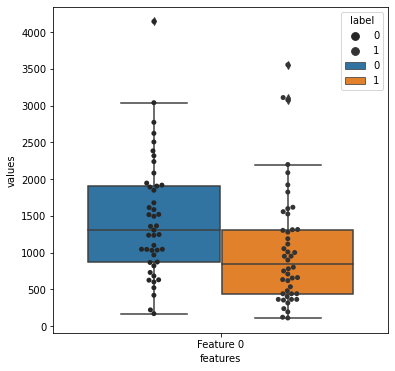

In [42]:
fig,ax_swarm1 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],split = True,ax = ax_swarm1,color = ".2")
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 0"])],ax = ax_swarm1)

Feature 1 : Neu CD64+MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

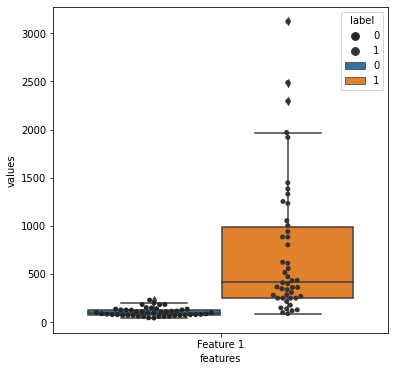

In [43]:
fig,ax_swarm2 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],split = True,ax = ax_swarm2,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 1"])],ax = ax_swarm2)

Feature 2 : CD3+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

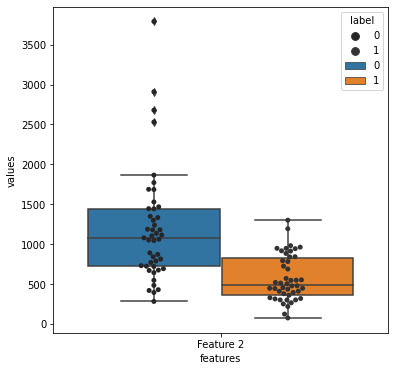

In [44]:
fig,ax_swarm3 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],split = True,ax = ax_swarm3,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 2"])],ax = ax_swarm3)

Feature 3 : CD8+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

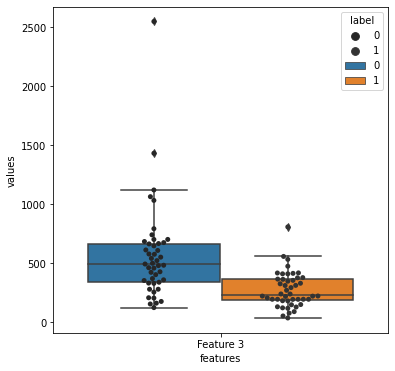

In [45]:
fig,ax_swarm4 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],split = True,ax = ax_swarm4,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 3"])],ax = ax_swarm4)

Feature 4 : CD4+T (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

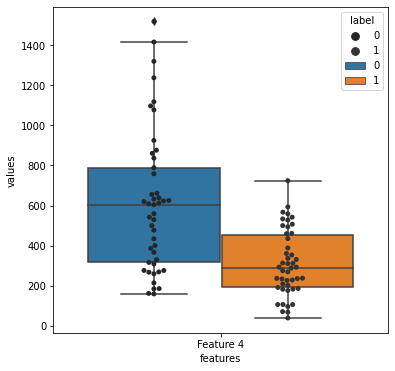

In [46]:
fig,ax_swarm5 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],split = True,ax = ax_swarm5,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 4"])],ax = ax_swarm5)

Feature 5 : NK (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

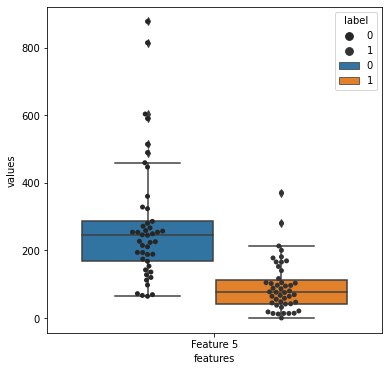

In [47]:
fig,ax_swarm6 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],split = True,ax = ax_swarm6,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 5"])],ax = ax_swarm6)

Feature 6 : CD19+ (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

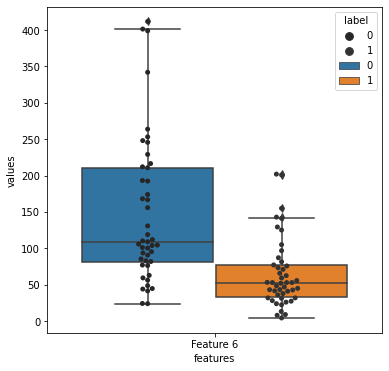

In [48]:
fig,ax_swarm7 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],split = True,ax = ax_swarm7,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 6"])],ax = ax_swarm7)

Feature 7 : CD45+ (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

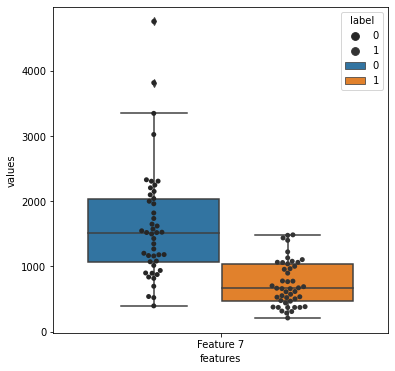

In [49]:
fig,ax_swarm8 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],split = True,ax = ax_swarm8,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 7"])],ax = ax_swarm8)

Feature 10: Mono CD64+MFI (cells/ul)

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='features', ylabel='values'>

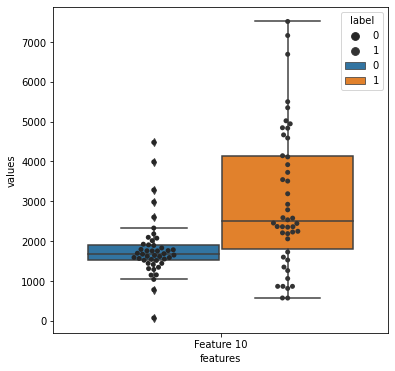

In [50]:
fig,ax_swarm9 = plt.subplots(1,1,figsize = (6,6))
sns.swarmplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],split = True,ax = ax_swarm9,color = '.2')
sns.boxplot(x = 'features',y = 'values',hue = 'label',data = df_eda_melt.loc[df_eda_melt["features"].isin(["Feature 10"])],ax = ax_swarm9)

Insight from swarm plots:

Features 0 show similar distributions between both classes and no useful separation. 

Features 2,3,4 show similar distributions between both classes and no useful separation. Also these 3 features show very similar distributions for each feature itself. This suggests high correlation. 

Feature 6,7 show similar distributions between both classes and no useful separation. 

Feature 1 shows that all instances of class label 0 are much lower than that of class label 1. Hence we can create a categorical attribute of high risk and low risk.

Feature 5 shows that all instances of class label 1 are concentrated below the 75th percentile. Hence we can create a categorical attribute with this feature anything below the 75th pecentile of Class label 1 is considered as high risk. 

In Feature 10, majority of the instances of class Label 0 are concentrated betwee the 25th and 75th percentiles hence all values of the 10th Feature below the 75th percentile can be considered as low risk. 

<h3>Removing highly correlated features</h3>

In [51]:
corr_matrix = df_eda[[i for i in df_eda.columns.tolist() if i not in ["Age","Sex","label"]]].corr().abs()
corr_matrix

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 10
Feature 0,1.000000,0.263394,0.105944,0.009312,0.195722,0.102913,0.106112,0.112364,0.409162
Feature 1,0.263394,1.000000,0.280856,0.287007,0.251498,0.365329,0.330622,0.329246,0.765205
Feature 2,0.105944,0.280856,1.000000,0.926215,0.922640,0.560427,0.754696,0.981109,0.312587
Feature 3,0.009312,0.287007,0.926215,1.000000,0.727821,0.515196,0.666202,0.906715,0.324752
Feature 4,0.195722,0.251498,0.922640,0.727821,1.000000,0.546877,0.720770,0.913052,0.268030
Feature 5,0.102913,0.365329,0.560427,0.515196,0.546877,1.000000,0.468906,0.698289,0.323996
Feature 6,0.106112,0.330622,0.754696,0.666202,0.720770,0.468906,1.000000,0.793829,0.426900
Feature 7,0.112364,0.329246,0.981109,0.906715,0.913052,0.698289,0.793829,1.000000,0.356392
Feature 10,0.409162,0.765205,0.312587,0.324752,0.268030,0.323996,0.426900,0.356392,1.000000


In [52]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(np.bool))

C:\Users\Pasindu.Samaranayake\AppData\Local\Temp\ipykernel_9696\2817667643.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k = 1).astype(np.bool))


In [53]:
upper

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 10
Feature 0,NaN,0.263394,0.105944,0.009312,0.195722,0.102913,0.106112,0.112364,0.409162
Feature 1,NaN,NaN,0.280856,0.287007,0.251498,0.365329,0.330622,0.329246,0.765205
Feature 2,NaN,NaN,NaN,0.926215,0.922640,0.560427,0.754696,0.981109,0.312587
Feature 3,NaN,NaN,NaN,NaN,0.727821,0.515196,0.666202,0.906715,0.324752
Feature 4,NaN,NaN,NaN,NaN,NaN,0.546877,0.720770,0.913052,0.268030
Feature 5,NaN,NaN,NaN,NaN,NaN,NaN,0.468906,0.698289,0.323996
Feature 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.793829,0.426900
Feature 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.356392
Feature 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As expected, from the above correlation matrix, we see that Features 2,3,4 are highly correlated. Also Feature 7 is highly correlated with Feature 2,3,4. Hence we shall remove all features with correlation above 0.9

In [54]:
cols_to_drop = set()
for i in range(upper.shape[1]):
    for j in range(i + 1,upper.shape[1]):
        if upper.iloc[i,j] > 0.9:
            cols_to_drop.add(upper.columns.tolist()[j])
cols_to_drop

{'Feature 3', 'Feature 4', 'Feature 7'}

Drop Features 3, 4 and 7

In [55]:
df_eda = df_eda.drop(list(cols_to_drop),axis = 1)
df_eda

,Feature 0,Feature 1,Feature 2,Feature 5,Feature 6,Age,Sex,Feature 10,label
86,122.092373,802.409850,916.221397,104.760076,46.789271,31,1,2363.308322,1
89,441.442294,359.188791,476.716189,96.394635,200.920150,30,0,574.129424,1
19,403.000000,555.000000,313.480000,46.680000,7.900000,40,0,2209.000000,1
53,1558.000000,611.000000,359.150000,20.620000,81.520000,49,1,2189.000000,1
26,2088.000000,98.000000,962.300000,370.880000,142.890000,51,1,1599.000000,1
...,...,...,...,...,...,...,...,...,...
38,1010.000000,1384.000000,570.130000,80.170000,31.180000,56,1,5501.000000,1
56,365.000000,248.000000,300.750000,13.420000,52.910000,41,1,866.000000,1
58,631.000000,182.000000,675.100000,136.000000,56.230000,29,1,3990.000000,0
42,1679.000000,79.000000,483.210000,227.050000,101.090000,39,0,4480.000000,0


In [56]:
df_eda[[i for i in df_eda.columns.tolist() if i not in ["Age","Sex","label"]]].corr().abs().where(np.triu(np.ones(df_eda[[i for i in df_eda.columns.tolist() if i not in ["Age","Sex","label"]]].corr().shape),k = 1).astype(bool))

,Feature 0,Feature 1,Feature 2,Feature 5,Feature 6,Feature 10
Feature 0,NaN,0.263394,0.105944,0.102913,0.106112,0.409162
Feature 1,NaN,NaN,0.280856,0.365329,0.330622,0.765205
Feature 2,NaN,NaN,NaN,0.560427,0.754696,0.312587
Feature 5,NaN,NaN,NaN,NaN,0.468906,0.323996
Feature 6,NaN,NaN,NaN,NaN,NaN,0.426900
Feature 10,NaN,NaN,NaN,NaN,NaN,NaN


As proven in the earlier Exploratory Data Analysis, both Age and Sex also have no meaningful correlation with the response variable. Hence we can drop these too

In [57]:
df_eda = df_eda.drop(["Age","Sex"],axis = 1)
df_eda

,Feature 0,Feature 1,Feature 2,Feature 5,Feature 6,Feature 10,label
86,122.092373,802.409850,916.221397,104.760076,46.789271,2363.308322,1
89,441.442294,359.188791,476.716189,96.394635,200.920150,574.129424,1
19,403.000000,555.000000,313.480000,46.680000,7.900000,2209.000000,1
53,1558.000000,611.000000,359.150000,20.620000,81.520000,2189.000000,1
26,2088.000000,98.000000,962.300000,370.880000,142.890000,1599.000000,1
...,...,...,...,...,...,...,...
38,1010.000000,1384.000000,570.130000,80.170000,31.180000,5501.000000,1
56,365.000000,248.000000,300.750000,13.420000,52.910000,866.000000,1
58,631.000000,182.000000,675.100000,136.000000,56.230000,3990.000000,0
42,1679.000000,79.000000,483.210000,227.050000,101.090000,4480.000000,0


Feature engineering

1) New categorical attribute will be created using feature 1. The instances with Feature 1 values < the 75th Percentile + 1.5IQR of feature 1 in class 0 will be considered as low risk

2) New categorical attribute will be created using feature 5. The instances with Feature 5 values < the 75th Percentile feature 5 in class 1 will be considered as high risk

3) New categorical attribute will be created using feature 10. The instances with Feature 10 values < the 75th Percentile feature 10 in class 0 will be considered as low risk

In [58]:
feature_eng = feature_engineering()
df_eda = feature_eng.feature0_fit_transform(df_eda)
df_eda = feature_eng.feature5_fit_transform(df_eda)
df_eda = feature_eng.feature10_fit_transform(df_eda)
df_eda

,Feature 0,Feature 1,Feature 2,Feature 5,Feature 6,Feature 10,label,Feature 1_Cat,Feature 5_Cat,Feature 10_Cat
86,122.092373,802.409850,916.221397,104.760076,46.789271,2363.308322,1,High Risk,High Risk,High Risk
89,441.442294,359.188791,476.716189,96.394635,200.920150,574.129424,1,High Risk,High Risk,Low Risk
19,403.000000,555.000000,313.480000,46.680000,7.900000,2209.000000,1,High Risk,High Risk,High Risk
53,1558.000000,611.000000,359.150000,20.620000,81.520000,2189.000000,1,High Risk,High Risk,High Risk
26,2088.000000,98.000000,962.300000,370.880000,142.890000,1599.000000,1,Low Risk,Low Risk,Low Risk
...,...,...,...,...,...,...,...,...,...,...
38,1010.000000,1384.000000,570.130000,80.170000,31.180000,5501.000000,1,High Risk,High Risk,High Risk
56,365.000000,248.000000,300.750000,13.420000,52.910000,866.000000,1,High Risk,High Risk,Low Risk
58,631.000000,182.000000,675.100000,136.000000,56.230000,3990.000000,0,Low Risk,Low Risk,High Risk
42,1679.000000,79.000000,483.210000,227.050000,101.090000,4480.000000,0,Low Risk,Low Risk,High Risk


Assessment of the feature engineering

3 new features are made:

- Feature 1_Cat
- Feature 5_Cat
- Feature 10_Cat

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

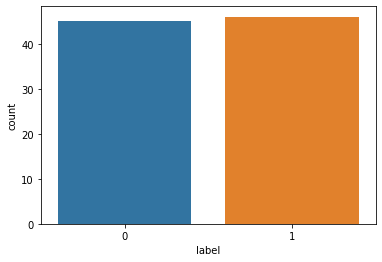

In [59]:
sns.countplot(df_eda["label"])

In [60]:
Counter(df_eda["label"])

Counter({1: 46, 0: 45})

There are 46 cases of Positive instances and 45 cases of negative instances. 

High Risk in Feature 1_Cat

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

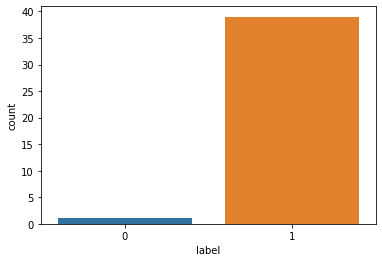

In [61]:
sns.countplot(df_eda.loc[(df_eda["Feature 1_Cat"] == "High Risk")]["label"])

In [62]:
Counter(df_eda.loc[(df_eda["Feature 1_Cat"] == "High Risk")]["label"])

Counter({1: 39, 0: 1})

Out of the 46 positive cases, Simply using the "Feature 1_Cat" = High Risk rule results in capturing 37 Positive cases being correctly classified and 1 Negative case being mistakenly classified as positive. That is a precision of 97% with recall of 80% from one feature. Hence this allows for a good rule.

High Risk in Feature 5_Cat

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

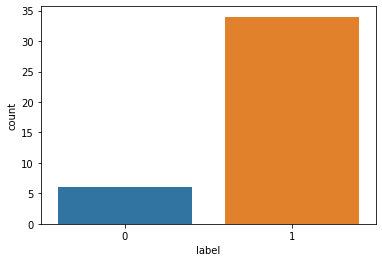

In [63]:
sns.countplot(df_eda.loc[(df_eda["Feature 5_Cat"] == "High Risk")]["label"])

In [64]:
Counter(df_eda.loc[(df_eda["Feature 5_Cat"] == "High Risk")]["label"])

Counter({1: 34, 0: 6})

Out of the 46 positive cases, Simply using the "Feature 5_Cat" = High Risk rule results in capturing 34 Positive cases being correctly classified and 5 Negative case being mistakenly classified as positive. That is a precision of 87% with recall of 74% from one feature. Hence this allows for a good rule.

High Risk in Feature 10_Cat

c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

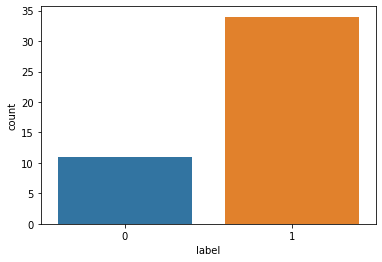

In [65]:
sns.countplot(df_eda.loc[(df_eda["Feature 10_Cat"] == "High Risk")]["label"])

In [66]:
Counter(df_eda.loc[(df_eda["Feature 10_Cat"] == "High Risk")]["label"])

Counter({1: 34, 0: 11})

"Feature 10_Cat" is not a good feature in comparison to "Feature 1_Cat" and "Feature 5_Cat". Nevertheless it can be used for the classifier

In [67]:
Counter(df_eda.loc[(df_eda["Feature 5_Cat"] == "High Risk")]["label"])

Counter({1: 34, 0: 6})

In [68]:
{k:grp.shape[0] for k,grp in df_eda.groupby("label")}

{0: 45, 1: 46}

In [69]:
df_eda_2 = df_eda.drop(["Feature 1","Feature 5","Feature 10"],axis = 1)

In [70]:
pd.concat([df_eda_2[[i for i in df_eda_2.columns.tolist() if "_" not in i and i != "label"]],pd.get_dummies(df_eda_2[['Feature 1_Cat','Feature 5_Cat','Feature 10_Cat',]]),df_eda_2[["label"]]],axis = 1)

,Feature 0,Feature 2,Feature 6,Feature 1_Cat_High Risk,Feature 1_Cat_Low Risk,Feature 5_Cat_High Risk,Feature 5_Cat_Low Risk,Feature 10_Cat_High Risk,Feature 10_Cat_Low Risk,label
86,122.092373,916.221397,46.789271,1,0,1,0,1,0,1
89,441.442294,476.716189,200.920150,1,0,1,0,0,1,1
19,403.000000,313.480000,7.900000,1,0,1,0,1,0,1
53,1558.000000,359.150000,81.520000,1,0,1,0,1,0,1
26,2088.000000,962.300000,142.890000,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
38,1010.000000,570.130000,31.180000,1,0,1,0,1,0,1
56,365.000000,300.750000,52.910000,1,0,1,0,0,1,1
58,631.000000,675.100000,56.230000,0,1,0,1,1,0,0
42,1679.000000,483.210000,101.090000,0,1,0,1,1,0,0


In [71]:
preprocess_training = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df_engineered = preprocess_training.read_df(process_complete = True)
df_engineered

,Feature 0,Feature 2,Feature 3,Feature 4,Feature 6,Feature 7,Age,label,Feature 1_Cat_High Risk,Feature 1_Cat_Low Risk,Feature 5_Cat_High Risk,Feature 5_Cat_Low Risk,Feature 10_Cat_High Risk,Feature 10_Cat_Low Risk,Sex_F,Sex_M
0,3.011549,-1.157638,-1.162070,-1.019024,-1.186040,-1.281719,1.127384,1,1,0,1,0,1,0,1,0
1,0.843318,0.753331,0.220262,1.224619,0.523741,0.523104,-1.993905,0,0,1,1,0,0,1,0,1
2,0.422813,0.575011,0.605789,0.516392,1.028176,0.630010,-1.213583,0,0,1,0,1,0,1,0,1
3,-0.763801,-0.907629,-0.642584,-1.065146,-0.763887,-0.990547,1.420005,0,0,1,1,0,0,1,0,1
4,-0.305187,0.201685,0.011530,0.420298,0.133918,0.134331,-1.213583,0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,-0.838703,1.287238,0.555639,1.998918,0.009503,1.245428,0.151981,0,0,1,0,1,0,1,0,1
82,-0.035801,0.600638,-0.140525,1.380563,-0.722277,0.256724,1.517545,0,0,1,0,1,0,1,1,0
83,-0.828191,0.521873,0.238038,0.736869,-0.134829,0.205496,-0.628341,1,1,0,1,0,1,0,1,0
84,-1.514140,-0.057819,-0.285061,0.233499,-0.898104,-0.274506,-0.725881,1,1,0,1,0,1,0,0,1


In [72]:
df_train_engineered = df_engineered[[i for i in df_engineered.columns.tolist() if i not in ["label"]]]
df_labels_engineered = df_engineered[[i for i in df_engineered.columns.tolist() if i in ["label"]]]

In [73]:
preprocess_training_plain = preprocess_data(filepath=str(Path(Path.cwd()/"Data"/"train.csv").resolve()))
df_plain = preprocess_training_plain.read_df()
df_test = preprocess_training_plain.read_df(process_complete=False,test_df=True, test_path=str(Path(Path.cwd()/"Data"/"test.csv").resolve()))
df_plain = df_plain.dropna(subset=["Feature 0","Feature 1","Feature 10"])
cols = [i for i in df_plain.columns.tolist() if i != "label"]
cols_scaling = [i for i in cols if i != "Sex"]
df_train_plain = df_plain[cols]
df_test_plain = df_test[cols]

df_train_plain.loc[df_train_plain["Sex"] == 0,"Sex"] = "F"
df_train_plain.loc[df_train_plain["Sex"] == 1,"Sex"] = "M"
df_test_plain.loc[df_test_plain["Sex"] == 0,"Sex"] = "F"
df_test_plain.loc[df_test_plain["Sex"] == 1,"Sex"] = "M"



df_labels_plain = df_plain[["label"]]
cols_scaling = [i for i in df_train_plain.columns.tolist() if i != "Sex"]
scaler_plain = StandardScaler()
scaler_plain.fit(df_train_plain[cols_scaling])
df_train_plain[cols_scaling] = scaler_plain.transform(df_train_plain[cols_scaling])
df_test_plain[cols_scaling] = scaler_plain.transform(df_test_plain[cols_scaling])

df_train_plain = pd.concat([df_train_plain[cols_scaling],pd.get_dummies(df_train_plain[["Sex"]])],axis = 1)
df_test_plain = pd.concat([df_test_plain[cols_scaling],pd.get_dummies(df_test_plain[["Sex"]])],axis = 1)
df_train_plain.head()
df_test_plain.head()

C:\Users\Pasindu.Samaranayake\AppData\Local\Temp\ipykernel_9696\813164227.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_plain.loc[df_train_plain["Sex"] == 0,"Sex"] = "F"
C:\Users\Pasindu.Samaranayake\AppData\Local\Temp\ipykernel_9696\813164227.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_plain[cols_scaling] = scaler_plain.transform(df_train_plain[cols_scaling])


,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Age,Feature 10,Sex_F,Sex_M
0,2.074610,-0.275702,0.616852,0.741525,0.460551,-0.505365,-0.240993,0.337435,0.444602,0.998365,0,1
1,-1.087064,-0.314682,-0.761233,-0.606887,-0.805667,1.020846,-0.205327,-0.403246,1.029844,-1.322408,0,1
2,-0.575888,-0.427520,0.411865,0.049849,0.801274,1.746461,2.108900,1.111113,-0.823421,-0.575396,1,0
3,-0.529895,-0.493171,0.867348,1.308976,0.307302,0.959462,-0.960781,0.767891,0.932304,-0.578754,1,0
4,-0.136985,-0.273650,-0.142881,-0.210986,-0.015171,0.303793,-0.315976,-0.088748,0.249522,-0.186782,1,0


In [74]:
first_layer_output = [15,16,17,18,19,20]
second_layer_output =[6,7,8,9]
combinations = list(product([i for i,j in enumerate(first_layer_output)],[i for i,j in enumerate(second_layer_output)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([first_layer_output[combination[0]],second_layer_output[combination[1]]])

Training a neural network on the dataset with no feature engineering

In [100]:
#TO UNCOMMENT
accuracy_list_plain = list()
for parameter_set in parameter_list:
# for units in first_layer_output:
    first_layer_output_units = parameter_set[0]
    second_layer_output_units = parameter_set[1]
    epoch_num = 10
    cross_val_splits = 5

    ksplitter = StratifiedKFold(n_splits = 5, shuffle = True,random_state = 42)
    model_score = 0
    model_loss = 0

    for train_idx,valid_idx in ksplitter.split(df_train_plain,df_labels_plain):
        layer_info_dict = {
            1:(df_train_plain.shape[1],first_layer_output_units,'elu'),
            # 1:(df_train.shape[1],units,'relu'),
            2:(first_layer_output_units,second_layer_output_units,'elu'),
            #output layer
            # 3:(second_layer_output_units,4,'elu'),
            3:(second_layer_output_units,1,'sigmoid')
        }
        
        model = NeuralNetwork(layer_info_dict)
        loss_fn = nn.BCELoss()
        X_train,y_train = df_train_plain.to_numpy()[train_idx],df_labels_plain.to_numpy()[train_idx]
        X_valid,y_valid = df_train_plain.to_numpy()[valid_idx],df_labels_plain.to_numpy()[valid_idx]

        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        trainvalidate = TrainingValidatingNetwork()
        optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
        accuracy,loss,model = trainvalidate.train_and_validate(train_dataloader,valid_dataloader,model,loss_fn,epochs=10,optimizer=optimizer)       
        model_score += accuracy
        model_loss += loss
    accuracy_list_plain.append((first_layer_output_units,second_layer_output_units,model_score/cross_val_splits,model))
    # accuracy_list.append((units,model_score/cross_val_splits))
    # print(f"First Layer : {first_layer_output_units}, Second Layer: {second_layer_output_units}, Accuracy : {model_score/cross_val_splits}, Loss: {model_loss/cross_val_splits}")

In [101]:
y_pred_list_train_noeng = list()
y_pred_list_test_noeng = list()
train_plain_np = df_train_plain.to_numpy()
test_plain_np = df_test_plain.to_numpy()
model_final_plain = sorted(accuracy_list_plain,key = lambda x:x[2],reverse=True)[0][3]

with torch.no_grad():
    for i in train_plain_np:
        y_pred_list_train_noeng.append(model_final_plain(torch.tensor(i).float()).round().detach().numpy()[0])


with torch.no_grad():
    for j in test_plain_np:
        y_pred_list_test_noeng.append(model_final_plain(torch.tensor(j).float()).round().detach().numpy()[0])

In [103]:
from sklearn.metrics import accuracy_score
accuracy_score(df_labels_plain.to_numpy().reshape(-1,),np.array(y_pred_list_train_noeng))

0.9069767441860465

In [ ]:
df_data = {'id':list(range(len(y_pred_list_test_noeng))),'label':[int(i) for i in y_pred_list_test_noeng]}
pd.DataFrame(df_data).to_csv("Submission.csv")

In [77]:
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import make_scorer
# parameters = {
#     'n_estimators':[10,50,100,200,300,400,500,1000],
#     'max_depth':[10,15,20],
#     'max_features':[4,5,6,7]
# }

# scoring = {"Accuracy":make_scorer(accuracy_score)}

# randforest = RandomForestClassifier(random_state=42)


# # rands = RandomizedSearchCV(estimator=randforest,param_distributions=parameters,scoring = scoring,refit = "Accuracy",cv = 5, return_train_score=True,random_state=42)
# rands = GridSearchCV(estimator=randforest,param_grid=parameters,scoring=scoring,refit = "Accuracy",cv = 5,return_train_score=True,verbose=0)

# rands.fit(df_train_plain.to_numpy(),df_labels_plain.to_numpy().reshape(-1,))

In [78]:
# rands.cv_results_

In [79]:
# rands.best_score_

In [80]:
# y_pred = rands.best_estimator_.predict(df_train_plain.to_numpy())

In [81]:
# y_pred

In [82]:
# df_labels_plain.to_numpy().reshape(-1,)

In [83]:
# accuracy_score(df_labels_plain.to_numpy().reshape(-1,),y_pred)

In [84]:
# y_test_pred = rands.best_estimator_.predict(df_test_plain.to_numpy())

In [85]:
# df_data = {'id':list(range(y_test_pred.shape[0])),'label':y_test_pred.tolist()}
# pd.DataFrame(df_data).to_csv("Submission.csv")

In [86]:
# layer_info_dict = {
#             1:(df_train.shape[1],5,'relu'),
#             2:(5,4,'relu'),
#             #output layer
#             3:(4,1,'sigmoid')
#         }
        
# model = NeuralNetwork(layer_info_dict)

In [87]:
# loss_fn = nn.BCELoss()
# for batch,(X,y) in enumerate(DataLoader(TensorDataset(torch.tensor(df_train.to_numpy()),torch.tensor(df_labels["labels"])),batch_sampler=None,batch_size=None)):
#     pred = model(X.float())
#     print(pred)
#     print(y.unsqueeze(0).float())
#     # print(loss_fn(pred,y.unsqueeze(0).float()))
#     print(y.unsqueeze(0).float().size())
#     print(pred.size())
#     break

Train a network with 2 hidden layers
First investigate the number of neurons in the 2 layers of the network

In [88]:
# ksplitter = StratifiedKFold(n_splits = 5, shuffle = True,random_state = 42)
# for train_idx,valid_idx in ksplitter.split(df_train,df_labels):
#         layer_info_dict = {
#             1:(df_train.shape[1],5,'relu'),
#             2:(5,4,'relu'),
#             #output layer
#             3:(4,1,'sigmoid')
#         }
        
#         model = NeuralNetwork(layer_info_dict)
#         loss_fn = nn.BCELoss()
#         X_train,y_train = df_train.to_numpy()[train_idx],df_labels.to_numpy()[train_idx]
#         X_valid,y_valid = df_train.to_numpy()[valid_idx],df_labels.to_numpy()[valid_idx]

#         ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
#         train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
#         ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
#         valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
#         for batch,(X,y) in  enumerate(train_dataloader):
#             pred = model(X.float())
#             print(pred)
#             print(y.unsqueeze(0).float())
#             # print(loss_fn(pred,y.unsqueeze(0).float()))
#             print(y.float().size())
#             print(pred.size())
#             print(pred.type())
#             print(y.type())
#             break
#         break


In [89]:
accuracy_list = list()
for parameter_set in parameter_list:
# for units in first_layer_output:
    first_layer_output_units = parameter_set[0]
    second_layer_output_units = parameter_set[1]
    epoch_num = 10
    cross_val_splits = 5

    ksplitter = StratifiedKFold(n_splits = 5, shuffle = True,random_state = 42)
    model_score = 0
    model_loss = 0

    for train_idx,valid_idx in ksplitter.split(df_train_engineered,df_labels_engineered):
        layer_info_dict = {
            1:(df_train_engineered.shape[1],first_layer_output_units,'elu'),
            # 1:(df_train.shape[1],units,'relu'),
            2:(first_layer_output_units,second_layer_output_units,'elu'),
            #output layer
            # 3:(second_layer_output_units,4,'elu'),
            3:(second_layer_output_units,1,'sigmoid')
        }
        
        model = NeuralNetwork(layer_info_dict)
        loss_fn = nn.BCELoss()
        X_train,y_train = df_train_engineered.to_numpy()[train_idx],df_labels_engineered.to_numpy()[train_idx]
        X_valid,y_valid = df_train_engineered.to_numpy()[valid_idx],df_labels_engineered.to_numpy()[valid_idx]

        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        trainvalidate = TrainingValidatingNetwork()
        optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
        accuracy,loss,model = trainvalidate.train_and_validate(train_dataloader,valid_dataloader,model,loss_fn,epochs=10,optimizer=optimizer)       
        model_score += accuracy
        model_loss += loss
    accuracy_list.append((first_layer_output_units,second_layer_output_units,model_score/cross_val_splits,model))
    # accuracy_list.append((units,model_score/cross_val_splits))
    # print(f"First Layer : {first_layer_output_units}, Second Layer: {second_layer_output_units}, Accuracy : {model_score/cross_val_splits}, Loss: {model_loss/cross_val_splits}")

In [90]:
sorted(accuracy_list,key = lambda x:x[2],reverse=True)[0]

(17,
 8,
 0.9058823529411765,
 NeuralNetwork(
   (linear_stack): Sequential(
     (0): Linear(in_features=15, out_features=17, bias=True)
     (1): ELU(alpha=1.0)
     (2): Linear(in_features=17, out_features=8, bias=True)
     (3): ELU(alpha=1.0)
     (4): Linear(in_features=8, out_features=1, bias=True)
     (5): Sigmoid()
   )
 ))

In [93]:
test_df = preprocess_training.read_df(process_complete = True,test_df=True,test_path=str(Path(Path.cwd(),"Data","test.csv").resolve()))
test_df.head()

,Feature 0,Feature 2,Feature 3,Feature 4,Feature 6,Feature 7,Age,Feature 1_Cat_High Risk,Feature 1_Cat_Low Risk,Feature 5_Cat_High Risk,Feature 5_Cat_Low Risk,Feature 10_Cat_High Risk,Feature 10_Cat_Low Risk,Sex_F,Sex_M
0,2.074610,0.616852,0.741525,0.460551,-0.240993,0.337435,0.444602,0,1,0,1,1,0,0,1
1,-1.087064,-0.761233,-0.606887,-0.805667,-0.205327,-0.403246,1.029844,0,1,0,1,0,1,0,1
2,-0.575888,0.411865,0.049849,0.801274,2.108900,1.111113,-0.823421,0,1,0,1,0,1,1,0
3,-0.529895,0.867348,1.308976,0.307302,-0.960781,0.767891,0.932304,0,1,0,1,0,1,1,0
4,-0.136985,-0.142881,-0.210986,-0.015171,-0.315976,-0.088748,0.249522,0,1,0,1,0,1,1,0


In [95]:
# layer_info_dict = {
#             1:(df_train_engineered.shape[1],15,'elu'),
#             # 1:(df_train.shape[1],units,'relu'),
#             2:(15,6,'elu'),
#             #output layer
#             # 3:(second_layer_output_units,4,'elu'),
#             3:(6,1,'sigmoid')
#         }
# model_feature_engineered = NeuralNetwork(layer_info_dict)
# loss_fn = nn.BCELoss()
# ds_train_feature_engineered = TensorDataset(torch.tensor(df_train_engineered.to_numpy()),torch.tensor(df_labels_engineered.to_numpy()))
# train_dataloader_feature_eng = DataLoader(ds_train_feature_engineered,batch_sampler=None,batch_size=None)
# trainvalidate = TrainingValidatingNetwork()
# optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
# model_feature_engineered = trainvalidate.train_and_validate(train_dataloader_feature_eng,None,model_feature_engineered,loss_fn,epochs=10,optimizer=optimizer,predicting = True)  

# y_pred_list = list()
# for batch,(X,y) in enumerate()
# y_pred_submission = model_feature_engineered(test_df.to_numpy())
model_final = sorted(accuracy_list,key = lambda x:x[2],reverse=True)[0][3]
y_pred_list_test = list()
y_pred_list_train = list()
test_np = test_df.to_numpy()
train_np = df_train_engineered.to_numpy()

with torch.no_grad():
    for i in train_np:
        y_pred_list_train.append(model_final(torch.tensor(i).float()).round().detach().numpy()[0])


with torch.no_grad():
    for j in test_np:
        y_pred_list_test.append(model_final(torch.tensor(j).float()).round().detach().numpy()[0])

In [98]:
from sklearn.metrics import accuracy_score
accuracy_score(df_labels_engineered.to_numpy().reshape(-1,),np.array(y_pred_list_train))

0.9186046511627907

In [ ]:
df_labels_engineered.to_numpy().reshape(-1,)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1],
      dtype=int64)

In [99]:
df_data = {'id':list(range(len(y_pred_list_test))),'label':[int(i) for i in y_pred_list_test]}
pd.DataFrame(df_data).to_csv("Submission.csv")

In [ ]:
rrrr

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
parameters = {
    'n_estimators':[10,50,100,200,300,400,500],
    'max_depth':[10,15,20],
    'max_features':[4,5,6,7]
}

scoring = {"Accuracy":make_scorer(accuracy_score)}

randforest = RandomForestClassifier(random_state=42)


# rands = RandomizedSearchCV(estimator=randforest,param_distributions=parameters,scoring = scoring,refit = "Accuracy",cv = 5, return_train_score=True,random_state=42)
rands = GridSearchCV(estimator=randforest,param_grid=parameters,scoring=scoring,refit = "Accuracy",cv = 5,return_train_score=True,verbose=1)

rands.fit(df_train,df_labels)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Pasindu.Samaranayake\Desktop\MSc\Predicting_Pneumonia\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\Users\Pasindu

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'max_features': [4, 5, 6, 7],
                         'n_estimators': [10, 50, 100, 200, 300, 400, 500]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=1)

In [ ]:
rands.cv_results_

{'mean_fit_time': array([0.0301971 , 0.08987551, 0.18635187, 0.38264356, 0.44453959,
        0.68315063, 0.73139572, 0.01905437, 0.07815561, 0.15774536,
        0.30884838, 0.47240548, 0.61767292, 0.73135424, 0.01930594,
        0.07936096, 0.15759993, 0.32282486, 0.45682969, 0.60816936,
        0.75822625, 0.01904187, 0.09484935, 0.1769577 , 0.31622844,
        0.51479139, 0.58926692, 0.73936462, 0.01850286, 0.07570381,
        0.15432959, 0.41599197, 0.43033309, 0.55409245, 0.73671236,
        0.01756387, 0.07314811, 0.1431313 , 0.3094399 , 1.19233932,
        0.63866262, 0.68293967, 0.01896973, 0.0772048 , 0.16374135,
        0.31033635, 0.42974677, 0.61735315, 0.72252688, 0.01434326,
        0.08554935, 0.17573972, 0.29838567, 0.43854723, 0.56806946,
        0.70945907, 0.01737213, 0.08053527, 0.1560637 , 0.29221711,
        0.44771447, 0.63723969, 0.69439635, 0.01361761, 0.07653966,
        0.14835968, 0.2860702 , 0.42196789, 0.58379707, 0.88139467,
        0.02076602, 0.08436666,

In [ ]:
rands.best_score_

0.8944664031620553

In [ ]:
rrrrr

NameError: name 'rrrrr' is not defined

In [ ]:
df_test = preprocess_training.process_test_df(filepath = Path(Path.cwd(),"Data","test.csv").resolve())
df_test

,Feature 0,Feature 2,Feature 6,Feature 1_Cat_High Risk,Feature 1_Cat_Low Risk,Feature 5_Cat_High Risk,Feature 5_Cat_Low Risk,Feature 10_Cat_High Risk,Feature 10_Cat_Low Risk
0,2.326481,0.824504,-0.119752,0,1,1,0,1,0
1,-1.028223,-0.643509,-0.080628,0,1,0,1,0,1
2,-0.485837,0.606140,2.457954,0,1,0,1,0,1
3,-0.437036,1.091346,-0.909320,0,1,0,1,0,1
4,-0.020138,0.015194,-0.202004,0,1,0,1,0,1
5,-0.428670,1.349388,-0.145377,0,1,0,1,0,1
6,0.216894,0.737072,1.249236,0,1,0,1,1,0
7,-0.948747,1.107822,-0.009588,0,1,0,1,0,1
8,1.317002,0.584425,-0.254054,0,1,1,0,1,0
9,1.223584,0.591324,0.553131,0,1,0,1,0,1


In [ ]:
preprocess_training.feature_eng.feature1boundary

208.5